Pobranie niezbędnych bibliotek

In [73]:
import pandas as pd
import string 
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.sentiment import SentimentAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#library used to count the frequency of words
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download('stopwords')
#nltk.download('wordnet') 
#nltk.download('omw-1.4')

Pobranie tekstów piosenek, sprawdzanie danych z jakimi mamy do czynienia

In [80]:
df=pd.read_csv('/projekt/Metallica_songs.csv', sep=';')
df.sample(5)

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics
13,"Atlas, Rise!",Metallica,"James Hetfield,Lars Ulrich",6:28,Hardwired... to Self-Destruct,Album,2.0,2016-11-18,https://www.metallica.com/songs/atlas-rise.html,"Bitterness and burden,Curses rest on thee,Soli..."
92,Instrumental Medley,Metallica,"James Hetfield,Lars Ulrich,Cliff Burton,Dave M...",NaN,NaN,NaN,NaN,NaN,https://www.metallica.com/songs/instrumental-m...,Instrumental
151,Poor Twisted Me,Metallica,"James Hetfield,Lars Ulrich",4:00,Load,Album,9.0,1996-06-04,https://www.metallica.com/songs/poor-twisted-m...,"Oh poor twisted me,Oh poor twisted me,I feast ..."
180,Sucking My Love,Diamond Head,"Sean Harris,Brian Tatler",NaN,NaN,NaN,NaN,NaN,https://www.metallica.com/songs/sucking-my-lov...,"Over and under,Dear girl down to the sea, ,Oh ..."
204,The Wait,Killing Joke,"Jaz Coleman,Paul Ferguson,Martin Glover,Kevin ...",4:55,The $5.98 E.P. – Garage Days Re-Revisited,Covers EP,3.0,1987-08-21,https://www.metallica.com/songs/the-wait.html,"Motives changing,Day to day,The fire increases..."


Usunięcie zbędnych kolumn

In [81]:
df = df.drop(columns=['Songwriters', 'Duration' ,'Album_type', 'No_on_album','Release_date', 'Link', 'Songwriters'])
df.head(5)

,Song,Author_band,Album,Lyrics
0,2 x 4,Metallica,Load,"I’m gonna make you shake you take you,I’m gonn..."
1,53rd & 3rd,The Ramones,We're a Happy Family: A Tribute to Ramones,"If you think you can well come on man,I was a ..."
2,72 Seasons,Metallica,72 Seasons,"Feeding on the wrath of man,Shot down,Traumati..."
3,Ain’t My Bitch,Metallica,Load,"Outta my way,Outta my day,Out of your mind and..."
4,All Day and All of the Night,The Kinks,NaN,"I’m not content to be with you in the daytime,..."


Przygotowanie niezbędnych funkcji

In [15]:
def clean_lyrics(df,column):
    #Funkcja usuwa didaskalia i przygotowuje tekst do dalszej obróbki 
    
    df['Lyrics'] = df['Lyrics'].str.lower()
    df['Lyrics'] = df['Lyrics'].str.replace(r"verse |[1|2|3]|chorus|bridge|outro"," ").str.replace("["," ").str.replace("]"," ")
    df['Lyrics'] = df['Lyrics'].str.lower().str.replace(r"instrumental|intro|guitar|solo","")
    df['Lyrics'] = df['Lyrics'].str.replace("\n"," ").str.replace(r"[^\w\d'\s]+"," ").str.replace("efil ym fo flah"," ")
    df['Lyrics'] = df['Lyrics'].str.strip()

    return df

def lyrics_to_words(document):
    #Funkcja dzieli tekst na pojedyncze słowa i normalizuje tekst
  
    stop_words = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())
    return normalized

In [82]:
df_cleaned = clean_lyrics(df,'Lyrics')
df = df[df['Lyrics'].notnull()]
df_cleaned.sample(5)

,Song,Author_band,Album,Lyrics
178,Stone Dead Forever,Motörhead,Hero of the Day Featuring the Whole Motörheada...,you think you see me in the glass you think yo...
151,Poor Twisted Me,Metallica,Load,oh poor twisted me oh poor twisted me i feast ...
21,Borderline,Thin Lizzy,NaN,midnight in the big city at the bar drinking a...
197,The Unforgiven,Metallica,Metallica,new blood joins this earth and quickly he s su...
18,Blackened,Metallica,...And Justice for All,blackened is the end winter it will send throw...


Ze zbioru utworów usuwam covery.

In [83]:
df_cleaned2 = df_cleaned[df_cleaned['Author_band'] == 'Metallica']
df_cleaned2.to_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/teksty.csv',index=False)
df_cleaned2.sample(5)

,Song,Author_band,Album,Lyrics
141,Of Wolf and Man,Metallica,Metallica,off through the new day s mist i run out from ...
197,The Unforgiven,Metallica,Metallica,new blood joins this earth and quickly he s su...
35,Creeping Death,Metallica,Ride the Lightning,slaves hebrews born to serve to the pharaoh he...
102,Kill/Ride Medley,Metallica,NaN,guilty as charged but damn it it ain t right t...
114,Lux Æterna,Metallica,72 Seasons,anticipation in domination a sea of hearts bea...


In [84]:
def unique(list1):
   #pusta lista
     unique_list = []
   #przejdź przez listę
     for x in list1:
         #sprawdź czy występuje w unique_list
         if x not in unique_list:
              unique_list.append(x)
     return unique_list

In [85]:
#Przechowuje unikalne słowa wszystkich piosenek w nowej kolumnie 'words'

#lista do przechowywania słów
words = []

#iteracja przez wszystkie teksty i dzieli unikalne słowa dodając je do listy słów
df_cleaned2 = df_cleaned2.reset_index(drop=True)
for word in df_cleaned2['Lyrics'].tolist():
    words.append(unique(lyrics_to_words(word).split()))
    
#dodaj zebrane słowa do kolumny 'words'
df_cleaned2['words'] = words
df_cleaned2.head()

,Song,Author_band,Album,Lyrics,words
0,2 x 4,Metallica,Load,i m gonna make you shake you take you i m gonn...,"[gonna, make, shake, take, one, break, put, sc..."
1,72 Seasons,Metallica,72 Seasons,feeding on the wrath of man shot down traumati...,"[feeding, wrath, man, shot, traumatic, time, h..."
2,Ain’t My Bitch,Metallica,Load,outta my way outta my day out of your mind and...,"[outta, way, day, mind, mine, one, step, time,..."
3,All Nightmare Long,Metallica,Death Magnetic,luck runs out crawl from the wreckage one ...,"[luck, run, crawl, wreckage, one, time, horrif..."
4,All Within My Hands,Metallica,St. Anger,all within my hands squeeze it in crush it dow...,"[within, hand, squeeze, crush, hold, dear, suf..."


In [86]:
#dodaję nową kolumnę, w której zawarta będzie informacja o liczbie wystąpień unikalnych słów
df_cleaned2['frequency'] = 0
df_cleaned2['frequency'] = df_cleaned2['frequency'].astype(int)
df = df_cleaned2

#puste listy
set_words = []
set_frequency = []

#tworzy listę słów z kolumny Lyrics i liczy liczbę wystąpień
for i in df.index:
    for word in df['words'].iloc[i]:
        set_words.append(word)
        set_frequency.append(df['frequency'].iloc[i])

#tworzy nowy data frame, który zawiera unikalne słowa i liczbę ich wystąpień
words_df = pd.DataFrame({'words':set_words,'frequency':set_frequency})

In [87]:
df.head()

,Song,Author_band,Album,Lyrics,words,frequency
0,2 x 4,Metallica,Load,i m gonna make you shake you take you i m gonn...,"[gonna, make, shake, take, one, break, put, sc...",0
1,72 Seasons,Metallica,72 Seasons,feeding on the wrath of man shot down traumati...,"[feeding, wrath, man, shot, traumatic, time, h...",0
2,Ain’t My Bitch,Metallica,Load,outta my way outta my day out of your mind and...,"[outta, way, day, mind, mine, one, step, time,...",0
3,All Nightmare Long,Metallica,Death Magnetic,luck runs out crawl from the wreckage one ...,"[luck, run, crawl, wreckage, one, time, horrif...",0
4,All Within My Hands,Metallica,St. Anger,all within my hands squeeze it in crush it dow...,"[within, hand, squeeze, crush, hold, dear, suf...",0


In [88]:
#Zbiór własnych stop_words wg potrzeb
stop_words = ['45','verse','im','get','1000','58','60','80','youre','youve',
               'guitar','solo','instrumental','intro','pre',"3","yo","yeah"]

#Policzy częstotliwość każdego ze słów z wyjątkiem tych z listy 'stop_words'          
cv = CountVectorizer(stop_words=stop_words)

#Stworzy dataframe o nazwie "data_cv" do przechowywania informacji o tym ile razy zostało użyte dane słowo
text_cv = cv.fit_transform(words_df['words'].iloc[:])
data_cv = pd.DataFrame(text_cv.toarray(),columns=cv.get_feature_names_out())
data_cv['frequency'] = words_df['frequency']

vect_words = data_cv.groupby('frequency').sum().T
vect_words = vect_words.reset_index(level=0).rename(columns ={'index':'words'})
vect_words = vect_words.rename_axis(columns='')

#Zapisze dane do plik
vect_words.to_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/words.csv',index=False)



In [89]:
words=pd.read_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/words.csv', sep=',')


In [47]:
words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   words   2828 non-null   object
 1   0       2828 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.3+ KB


In [90]:
words.rename(columns={'0': 'frequency'}, inplace=True)

# Sprawdzenie zmian
words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   words      2828 non-null   object
 1   frequency  2828 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.3+ KB


In [91]:
words_sorted = words.sort_values(by='frequency', ascending=False)
words_sorted.head(20)

,words,frequency
1395,life,57
1628,never,54
2457,take,53
2098,see,52
123,away,48
2538,time,48
429,come,47
1683,one,46
858,feel,45
2061,say,40


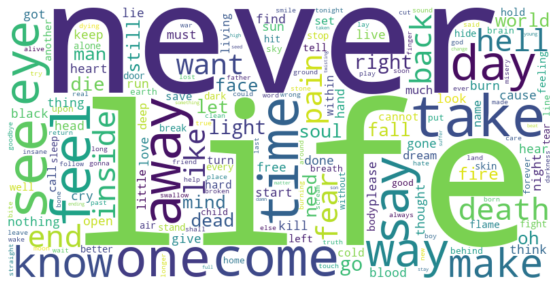

In [92]:
#tworzy słownik z df
word_freq = dict(zip(words_sorted['words'], words_sorted['frequency']))

font_path = 'C:/Windows/Fonts/arial.ttf'

# Generowanie chmury słów
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Wyświetlenie chmury słów
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [93]:
def words_stats(df,main_df):
    unique_words = []
    total_words = []
    total_news = []
    years = []
    for value in df.columns[1:]:
         unique_words.append(np.count_nonzero(df[value]))
         total_words.append(sum(df[value]))
         years.append(str(value))
         total_news.append(main_df['frequency'][main_df['frequency']==value].count())
    
    data = pd.DataFrame({'unique words':unique_words,'total words':total_words,'total songs':total_news})
    data['words per songs'] = round(data['total words'] / data['total songs'],0)
    data['words per songs'] = data['words per songs'].astype('int')
    return data


In [56]:
words_stats(vect_words,df)

,unique words,total words,total songs,words per songs
0,2828,8646,147,59


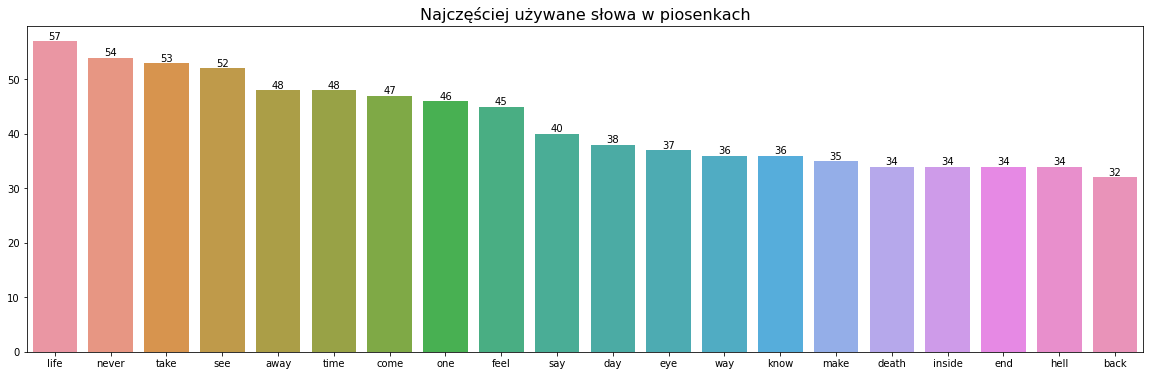

In [94]:
df_word_stats = pd.DataFrame(words_sorted.head(20))
plt.figure(figsize=(20, 6))
ax = sns.barplot(x='words', y='frequency', data=df_word_stats)

# Dodanie tytułu i etykiet osi
plt.title('Najczęściej używane słowa w piosenkach', fontsize=16)
plt.xlabel('')
plt.ylabel('')

#Dodanie wartości nad słupkiem
for i in ax.containers:
    ax.bar_label(i,)

# Wyświetlenie wykresu
plt.show()

Analiza sentymentu

In [95]:
#Sentiment Analysis using VADER Sentiment Intensinty Model
"""
neg: ujemny sentyment (negative)
neu: neutralny sentyment (neutral)
pos: pozytywny sentyment (positive)
compound: skumulowany wynik sentymentu, który podsumowuje wszystkie trzy powyższe wartości 
i normalizuje wynik do zakresu od -1 (najbardziej negatywny) do +1 (najbardziej pozytywny)
"""
#Tworzy puste listy

negative = []
neutral = []
positive = []
compound = []

#Initialize the model
sid = SentimentIntensityAnalyzer()

#Iterate for each row of lyrics and append the scores
for i in df.index:
    scores = sid.polarity_scores(df['Lyrics'].iloc[i])
    negative.append(scores['neg'])
    neutral.append(scores['neu'])
    positive.append(scores['pos'])
    compound.append(scores['compound'])

#Create 4 columns to the main data frame  for each score 
df['negative'] = negative
df['neutral'] = neutral
df['positive'] = positive
df['compound'] = compound

In [96]:
df.head()

,Song,Author_band,Album,Lyrics,words,frequency,negative,neutral,positive,compound
0,2 x 4,Metallica,Load,i m gonna make you shake you take you i m gonn...,"[gonna, make, shake, take, one, break, put, sc...",0,0.089,0.884,0.027,-0.9549
1,72 Seasons,Metallica,72 Seasons,feeding on the wrath of man shot down traumati...,"[feeding, wrath, man, shot, traumatic, time, h...",0,0.270,0.730,0.000,-0.9979
2,Ain’t My Bitch,Metallica,Load,outta my way outta my day out of your mind and...,"[outta, way, day, mind, mine, one, step, time,...",0,0.253,0.669,0.078,-0.9979
3,All Nightmare Long,Metallica,Death Magnetic,luck runs out crawl from the wreckage one ...,"[luck, run, crawl, wreckage, one, time, horrif...",0,0.104,0.791,0.105,0.7462
4,All Within My Hands,Metallica,St. Anger,all within my hands squeeze it in crush it dow...,"[within, hand, squeeze, crush, hold, dear, suf...",0,0.314,0.580,0.106,-0.9971


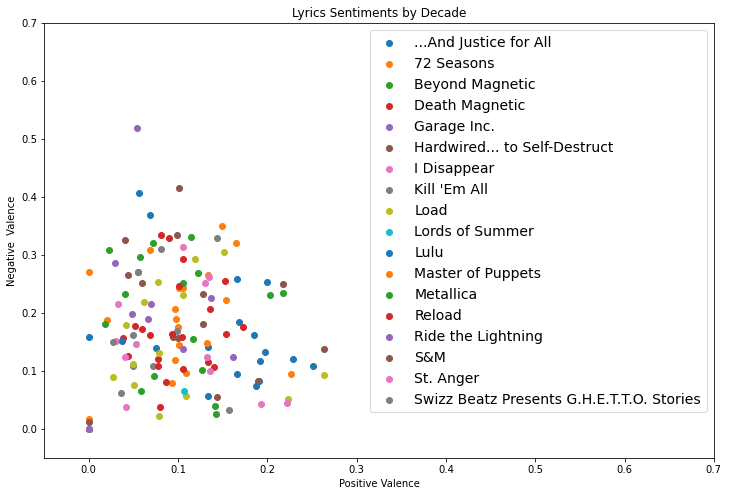

In [104]:
plt.figure(figsize=(12, 8))
for name, group in df.groupby('Album'):
    plt.scatter(group['positive'],group['negative'],label=name)
    plt.legend(fontsize=14)

plt.xlim([-0.05,0.7])
plt.ylim([-0.05,0.7])

plt.title("Analiza sentymentu wg albumów")
plt.xlabel('Wydźwięk pozytywny')
plt.ylabel('Wydźwięk negatywny')
plt.show()